In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
test_set_start_date = pd.to_datetime('2019-12-01')
prediction_period = 7

In [3]:
def model_metrics(y_true, predictions, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)
    mea = mean_absolute_error(y_true=y_true, y_pred=predictions)

    return pd.DataFrame(data = [{'Model': model_name, 'rmse': rmse, 'r2': r2, 'mea' : mea}])

### Data Preparation

In [4]:
restaurant_data = pd.read_csv('Data/RestaurantData.csv', names = ['Location', 'Date', 'Sales'],  infer_datetime_format=True)
restaurant_data.Date = pd.to_datetime(restaurant_data.Date)
agg_data = restaurant_data.groupby('Date')[['Sales']].mean()
date_range = pd.date_range(agg_data.index.min(), agg_data.index.max())
agg_data = agg_data.reindex(date_range, fill_value = 0)
agg_data = agg_data.asfreq(pd.infer_freq(agg_data.index))
agg_data.to_csv('Data/AggData.csv')

In [5]:
agg_data_train = agg_data[agg_data.index < test_set_start_date]
agg_data_test = agg_data[agg_data.index >= test_set_start_date]

### EDA

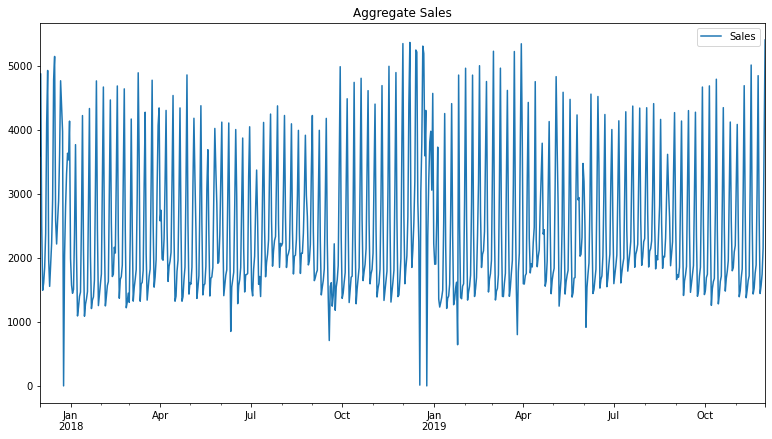

In [6]:
agg_data_train.plot(figsize = (13,7), legend=True, title = 'Aggregate Sales');

##### Seasonal Decomposition on the whole training data set

<AxesSubplot:>

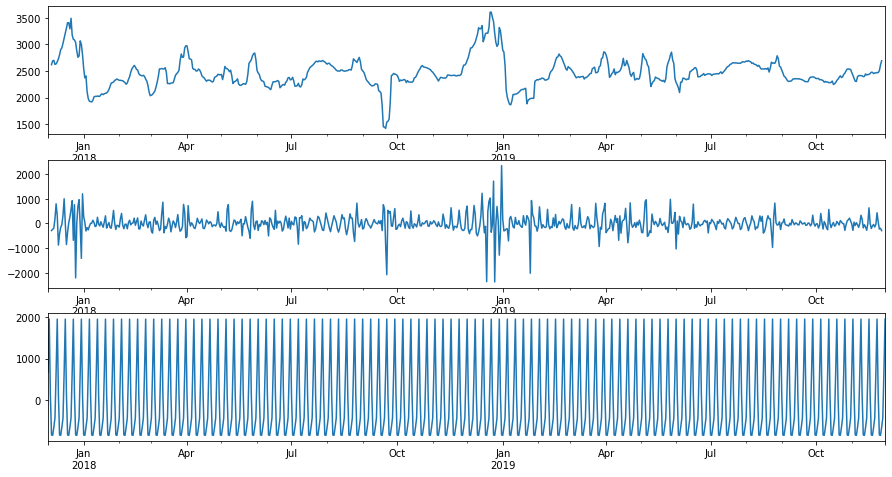

In [7]:
decomposed_data = seasonal_decompose(agg_data_train)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decomposed_data.trend.plot(ax=ax1)
decomposed_data.resid.plot(ax=ax2)
decomposed_data.seasonal.plot(ax=ax3)

##### Seasonal decomposition on only 30 days

<AxesSubplot:>

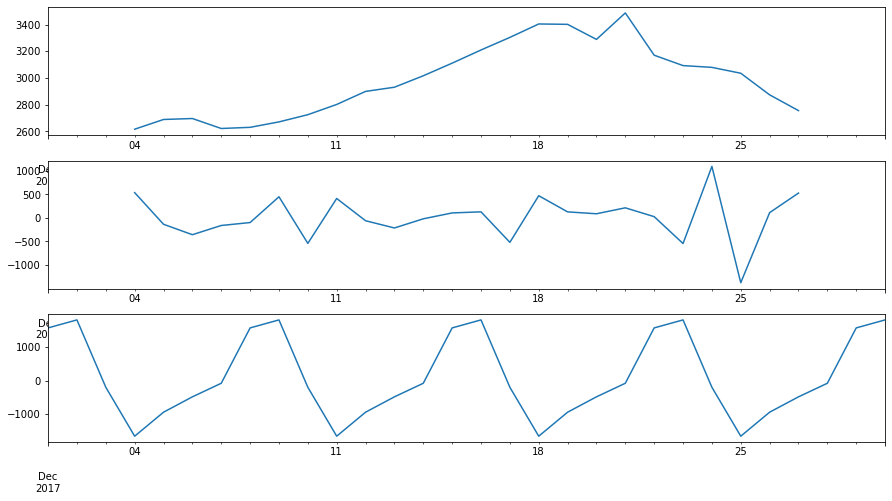

In [8]:
decomposed_data = seasonal_decompose(agg_data_train[:30])
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decomposed_data.trend.plot(ax=ax1)
decomposed_data.resid.plot(ax=ax2)
decomposed_data.seasonal.plot(ax=ax3)

### Modeling

In [9]:
seven_days_predictions = pd.DataFrame()
for i in range(len(agg_data_test) - prediction_period + 1):
    start_time = agg_data_test.index.min() + datetime.timedelta(days=i)
    end_time = start_time + datetime.timedelta(days = (prediction_period-1))
    if i != 0:
        agg_train_set = agg_data_train.append(agg_data_test[i - 1:i])
    fitted_model = ExponentialSmoothing(agg_data_train, trend='add',seasonal='add',seasonal_periods=7).fit()
    seven_days_prediction = fitted_model.predict(start=start_time, end=end_time).rename('HW Forecast')
    pred = pd.DataFrame({"Forecast": seven_days_prediction, "Sales": agg_data_test.loc[start_time: end_time, 'Sales']})
    seven_days_predictions = pd.concat([seven_days_predictions, pred])

/home/user/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [10]:
seven_days_predictions

,Forecast,Sales
2019-12-01,2880.949740,2904.140663
2019-12-02,1790.980522,1639.442484
2019-12-03,1920.389655,1797.274824
2019-12-04,2107.581438,2062.645921
2019-12-05,2285.285790,2516.151760
...,...,...
2019-12-27,3623.049905,3721.443247
2019-12-28,4994.658008,4322.630757
2019-12-29,3007.805894,3258.119591
2019-12-30,1917.836676,3350.462127


In [11]:
average_seven_days_predictions = seven_days_predictions.groupby(seven_days_predictions.index).mean()

In [12]:
average_seven_days_predictions.loc['2019-12-25', 'Forecast'] = 0

In [13]:
average_seven_days_predictions

,Forecast,Sales
2019-12-01,2880.949740,2904.140663
2019-12-02,1790.980522,1639.442484
2019-12-03,1920.389655,1797.274824
2019-12-04,2107.581438,2062.645921
2019-12-05,2285.285790,2516.151760
2019-12-06,3527.907789,4226.356679
2019-12-07,4899.515893,5345.861532
2019-12-08,2912.663779,2904.614907
2019-12-09,1822.694560,1766.683909
2019-12-10,1952.103693,1960.145135


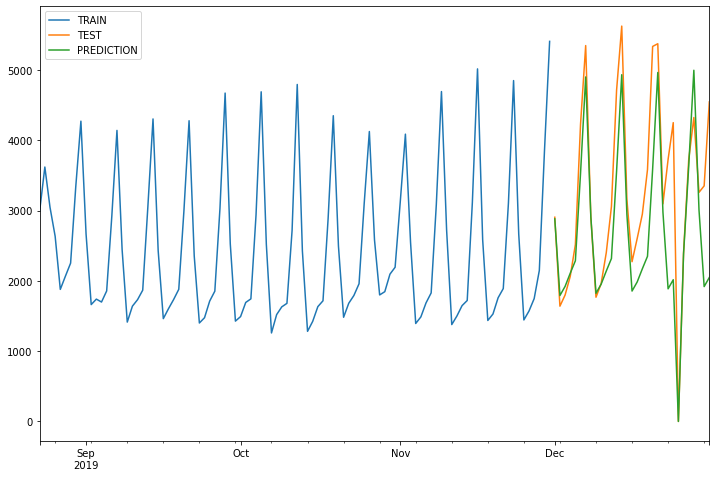

In [14]:
agg_data_train['Sales'][-100:].plot(legend=True,label='TRAIN')
agg_data_test['Sales'].plot(legend=True,label='TEST',figsize=(12,8))
average_seven_days_predictions['Forecast'].plot(legend=True,label='PREDICTION');

In [15]:
fitted_model.params

{'smoothing_level': 0.18160360419966926,
 'smoothing_trend': 0.01530040071040025,
 'smoothing_seasonal': 0.15804611428351298,
 'damping_trend': nan,
 'initial_level': 3151.6007847169926,
 'initial_trend': -2.028579292428656,
 'initial_seasons': array([  441.16050299,  1726.06958408,  -642.39185205, -1657.41291527,
        -1540.6239773 , -1296.87329426,  -771.27880448]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [16]:
model_metrics(y_true=average_seven_days_predictions['Sales'], predictions=average_seven_days_predictions['Forecast'], model_name = 'Holt Winters')

,Model,rmse,r2,mea
0,Holt Winters,921.82586,0.479946,619.717595
